In [2]:
# If editable install isn't active, add ../src to sys.path:
# import sys, os; sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tngmw.paths import CATALOG, FIGURES
from tngmw.io_hdf5 import load_hdf5_to_dataframe

plt.rcParams['figure.dpi'] = 140
plt.rcParams['axes.grid'] = True

## Load the catalog

In [3]:
print(f"[info] Loading: {CATALOG}")
df = load_hdf5_to_dataframe(CATALOG)
print(f"[info] Table shape: {df.shape}")
df.head(3)

# print the columns for reference
print('********** COLUMNS **********')
print(df.columns.tolist())

[info] Loading: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/catalog/mwm31s_hostcatalog.hdf5
[info] Table shape: (198, 28)
********** COLUMNS **********
['DiskScaleHeightThick_8kpc', 'DiskScaleHeightThin_8kpc', 'DiskScaleLength', 'FlagBarredRosas22', 'FlagBarredZana22', 'FlagCentral', 'FlagDisky', 'FlagDiskyMinor2Major', 'FlagDiskyVisual', 'FlagIsolated', 'FlagM200c', 'FlagMWM31', 'FlagMstars', 'FlagNoVirgo', 'FlagS0', 'HaloMass_M200c', 'HaloMass_Mdyn', 'HaloVirialRadius_R200c', 'SFR_50Myr', 'SFR_inst', 'SMBH_AccretionRate', 'SMBH_EddingtonRatio', 'SMBH_FeedbackMode', 'SMBH_Mass', 'StellarMass_2rh', 'StellarMass_30kpc', 'StellarMass_all', 'SubfindID']


In [4]:
def pick_col(df, names):
    for n in names:
        if n in df.columns:
            return df[n].astype(float)
    raise KeyError(f"None of {names} found")

sfr = pick_col(df, ["SFR_50Myr", "SFR_inst"])                 # Msun/yr
mstar_raw = pick_col(df, ["StellarMass_30kpc", "StellarMass_all", "StellarMass_2rh"])  # often in 1e10 Msun
subid = pick_col(df, ["SubfindID"])                           # integer id

# Heuristic: if med(M*) < 1e3, treat as 1e10 Msun units and scale to Msun
if np.nanmedian(mstar_raw) < 1e3:
    mstar_msun = mstar_raw * 1e10
    mstar_unit = r"M$_\odot$ (assumed ×1e10)"
else:
    mstar_msun = mstar_raw
    mstar_unit = r"M$_\odot$"

with np.errstate(divide='ignore', invalid='ignore'):
    ssfr = sfr / mstar_msun
log10_ssfr = np.log10(np.where(ssfr > 0, ssfr, np.nan))

df_en = df.copy()
df_en["Mstar_Msun"] = mstar_msun
df_en["SFR_Msun_per_yr"] = sfr
df_en["sSFR_1_per_yr"] = ssfr
df_en["log10_sSFR"] = log10_ssfr

df_en[["SubfindID","Mstar_Msun","SFR_Msun_per_yr","log10_sSFR"]].head()

,SubfindID,Mstar_Msun,SFR_Msun_per_yr,log10_sSFR
0,342447,9.083299e+10,14.861679,-9.786176
1,358609,9.303855e+10,0.188990,-11.692223
2,372754,1.536106e+11,1.615221,-10.978189
3,372755,6.592498e+10,11.300122,-9.765967
4,388544,1.363020e+11,8.456196,-10.207327


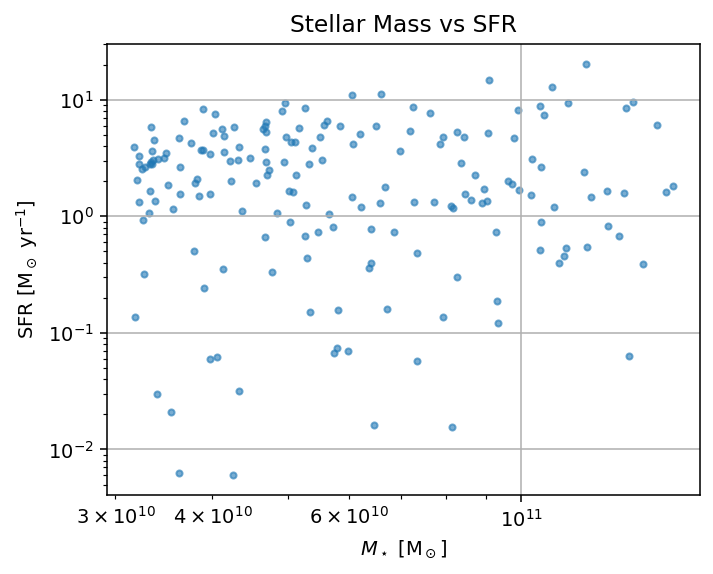

In [5]:
fig, ax = plt.subplots(figsize=(5.2, 4.2))
ax.scatter(df_en["Mstar_Msun"], df_en["SFR_Msun_per_yr"], s=10, alpha=0.6)
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel(fr"$M_\star$ [{mstar_unit}]")
ax.set_ylabel(r"SFR [M$_\odot$ yr$^{-1}$]")
ax.set_title("Stellar Mass vs SFR")
plt.tight_layout()
# Optional save:
# (FIGURES / "mstar_vs_sfr.png").parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(FIGURES / "mstar_vs_sfr.png", dpi=200)
plt.show()

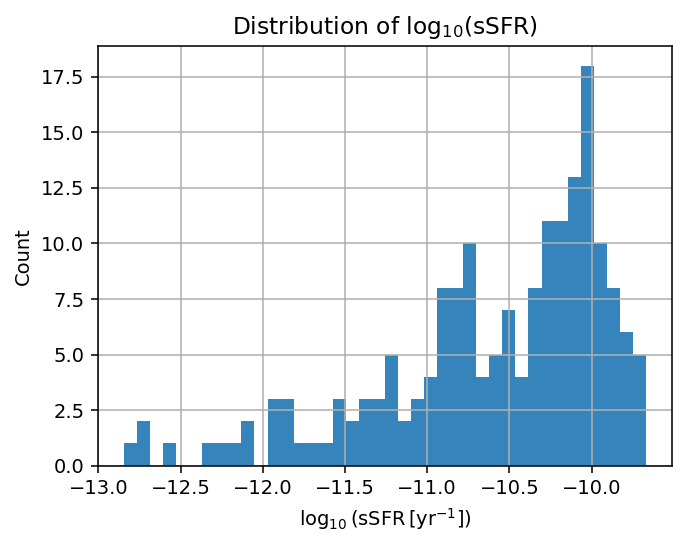

In [6]:
vals = df_en["log10_sSFR"].to_numpy()
vals = vals[np.isfinite(vals)]

fig, ax = plt.subplots(figsize=(5.0, 4.0))
ax.hist(vals, bins=40, alpha=0.9)
ax.set_xlabel(r"$\log_{10}(\mathrm{sSFR}\,[\mathrm{yr}^{-1}])$")
ax.set_ylabel("Count")
ax.set_title("Distribution of log$_{10}$(sSFR)")
plt.tight_layout()
# plt.savefig(FIGURES / "hist_log10_ssfr.png", dpi=200)
plt.show()

In [7]:
TARGET = 432106
row = df_en.loc[subid.astype(int) == TARGET]
if row.empty:
    print(f"[warn] SubfindID {TARGET} not in catalog.")
else:
    print(f"[ok] SubfindID {TARGET} found ({len(row)} row). Full stats below:")
    display(row.T)   # transpose for readability

[ok] SubfindID 432106 found (1 row). Full stats below:


,22
DiskScaleHeightThick_8kpc,1.375000e+03
DiskScaleHeightThin_8kpc,4.700000e+02
DiskScaleLength,6.630000e+00
FlagBarredRosas22,1.000000e+00
FlagBarredZana22,1.000000e+00
FlagCentral,1.000000e+00
FlagDisky,1.000000e+00
FlagDiskyMinor2Major,1.000000e+00
FlagDiskyVisual,1.000000e+00
FlagIsolated,1.000000e+00


In [8]:
TARGET = 509091
row = df_en.loc[subid.astype(int) == TARGET]
if row.empty:
    print(f"[warn] SubfindID {TARGET} not in catalog.")
else:
    print(f"[ok] SubfindID {TARGET} found ({len(row)} row). Full stats below:")
    display(row.T)   # transpose for readability

[ok] SubfindID 509091 found (1 row). Full stats below:


,93
DiskScaleHeightThick_8kpc,1.460000e+03
DiskScaleHeightThin_8kpc,4.950000e+02
DiskScaleLength,9.050000e+00
FlagBarredRosas22,1.000000e+00
FlagBarredZana22,0.000000e+00
FlagCentral,1.000000e+00
FlagDisky,1.000000e+00
FlagDiskyMinor2Major,1.000000e+00
FlagDiskyVisual,1.000000e+00
FlagIsolated,1.000000e+00


In [8]:
TARGET = 535050
row = df_en.loc[subid.astype(int) == TARGET]
if row.empty:
    print(f"[warn] SubfindID {TARGET} not in catalog.")
else:
    print(f"[ok] SubfindID {TARGET} found ({len(row)} row). Full stats below:")
    display(row.T)   # transpose for readability

[ok] SubfindID 535050 found (1 row). Full stats below:


,130
DiskScaleHeightThick_8kpc,8.950000e+02
DiskScaleHeightThin_8kpc,3.750000e+02
DiskScaleLength,8.310000e+00
FlagBarredRosas22,1.000000e+00
FlagBarredZana22,1.000000e+00
FlagCentral,1.000000e+00
FlagDisky,1.000000e+00
FlagDiskyMinor2Major,1.000000e+00
FlagDiskyVisual,1.000000e+00
FlagIsolated,1.000000e+00


In [12]:
import sys, os, pathlib
# assuming this notebook is in notebooks/ under repo root
ROOT = pathlib.Path("..").resolve()
sys.path.insert(0, str(ROOT))

In [13]:
from scripts.download_tng import (
    get_json, download_binary, load_tng_api_key, S, BASE, RAW, PROCESSED
)

In [14]:
api_key = load_tng_api_key()
print(f"[ok] Loaded API key: {api_key[:6]}********")  # confirm masked

# test simple GET
import requests
r = requests.get(BASE, headers={"api-key": api_key})
r.raise_for_status()
print("[ok] Connection success")

[ok] Loaded API key: 7f3b66********
[ok] Connection success


In [16]:
import json
detail = get_json(BASE)
out = PROCESSED / "subhalo_432106_detail.json"
out.write_text(json.dumps(detail, indent=2))
print(f"[ok] Wrote detail JSON → {out}")

[ok] Wrote detail JSON → /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/processed/subhalo_432106_detail.json


In [25]:
import os
import requests
from pathlib import Path

from tngmw.config import RAW, SIMULATION, SNAPNUM, SUBID, TNG_API_KEY

# Ensure RAW directory exists
RAW.mkdir(parents=True, exist_ok=True)

# Setup
headers = {"api-key": TNG_API_KEY}
base_url = f"https://www.tng-project.org/api/{SIMULATION}/snapshots/{SNAPNUM}/subhalos/{SUBID}/"
cutout_url = base_url + "cutout.hdf5"

outfile = RAW / f"subhalo_{SUBID}_cutout_full.hdf5"
print(f"[info] Downloading full cutout → {outfile}")

with requests.get(cutout_url, headers=headers, stream=True) as r:
    r.raise_for_status()
    with open(outfile, "wb") as f:
        for chunk in r.iter_content(chunk_size=1<<20):
            if chunk:
                f.write(chunk)

print(f"[ok] Download complete: {outfile}")

[info] Downloading full cutout → /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/raw/subhalo_432106_cutout_full.hdf5
[ok] Download complete: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/raw/subhalo_432106_cutout_full.hdf5


In [9]:
import os
import requests
from pathlib import Path

from tngmw.config import RAW, SIMULATION, SNAPNUM, SUBID, TNG_API_KEY

# Ensure RAW directory exists
RAW.mkdir(parents=True, exist_ok=True)

SUBID = 509091  # updated subhalo ID

# Setup
headers = {"api-key": TNG_API_KEY}
base_url = f"https://www.tng-project.org/api/{SIMULATION}/snapshots/{SNAPNUM}/subhalos/{SUBID}/"
cutout_url = base_url + "cutout.hdf5"

outfile = RAW / f"subhalo_{SUBID}_cutout_full.hdf5"
print(f"[info] Downloading full cutout → {outfile}")

with requests.get(cutout_url, headers=headers, stream=True) as r:
    r.raise_for_status()
    with open(outfile, "wb") as f:
        for chunk in r.iter_content(chunk_size=1<<20):
            if chunk:
                f.write(chunk)

print(f"[ok] Download complete: {outfile}")

[info] Downloading full cutout → /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/raw/subhalo_509091_cutout_full.hdf5
[ok] Download complete: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/raw/subhalo_509091_cutout_full.hdf5


In [9]:
import os
import requests
from pathlib import Path

from tngmw.config import RAW, SIMULATION, SNAPNUM, SUBID, TNG_API_KEY

# Ensure RAW directory exists
RAW.mkdir(parents=True, exist_ok=True)

SUBID = 535050  # updated subhalo ID

# Setup
headers = {"api-key": TNG_API_KEY}
base_url = f"https://www.tng-project.org/api/{SIMULATION}/snapshots/{SNAPNUM}/subhalos/{SUBID}/"
cutout_url = base_url + "cutout.hdf5"

outfile = RAW / f"subhalo_{SUBID}_cutout_full.hdf5"
print(f"[info] Downloading full cutout → {outfile}")

with requests.get(cutout_url, headers=headers, stream=True) as r:
    r.raise_for_status()
    with open(outfile, "wb") as f:
        for chunk in r.iter_content(chunk_size=1<<20):
            if chunk:
                f.write(chunk)

print(f"[ok] Download complete: {outfile}")

[info] Downloading full cutout → /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/raw/subhalo_535050_cutout_full.hdf5
[ok] Download complete: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/raw/subhalo_535050_cutout_full.hdf5
